In [57]:
import copy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [10]:
data = pd.read_csv("data/iris/iris.data", header=None)

In [32]:
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [33]:
X,y = data.iloc[:, 0:4], data.iloc[:, 4:]

In [34]:
#help(OneHotEncoder)

In [35]:
# Encoding the y variable
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)

In [36]:
help(ohe.transform)

Help on method transform in module sklearn.preprocessing._encoders:

transform(X) method of sklearn.preprocessing._encoders.OneHotEncoder instance
    Transform X using one-hot encoding.
    
    If there are infrequent categories for a feature, the infrequent
    categories will be grouped into a single category.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The data to encode.
    
    Returns
    -------
    X_out : {ndarray, sparse matrix} of shape                 (n_samples, n_encoded_features)
        Transformed input. If `sparse_output=True`, a sparse matrix will be
        returned.



In [37]:
# transform gives output in numpy array
y = ohe.transform(y)

In [38]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [40]:
X_train.shape

torch.Size([120, 4])

In [70]:
# Model

class Multiclass(nn.Module):

    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        return self.output(self.act(self.hidden(x)))    

In [71]:
model = Multiclass()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
epochs = 200
batch_size = 5
batches_per_epoch = len(X_train) // 5

best_acc = -np.inf
best_weights = None

train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(epochs):

    epoch_loss = []
    epoch_acc = []

    # set model to train mode
    model.train()
    for i in range(batches_per_epoch):

        start = i * batch_size
        end = start + batch_size

        Xb = X_train[start:end]
        Yb = y_train[start:end]

        y_pred = model(Xb)
        loss = loss_fn(y_pred, Yb)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        acc = (torch.argmax(y_pred, 1) == torch.argmax(Yb, 1)).float().mean()

        epoch_loss.append(float(loss))
        epoch_acc.append(float(acc))

    model.eval()
    y_pred = model(X_test)

    cross_entropy = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))

    test_loss_hist.append(np.mean(cross_entropy.detach().numpy()))
    test_acc_hist.append(np.mean(acc.detach().numpy()))

    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={cross_entropy:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0 validation: Cross-entropy=1.19, Accuracy=40.0%
Epoch 1 validation: Cross-entropy=1.10, Accuracy=40.0%
Epoch 2 validation: Cross-entropy=1.06, Accuracy=56.7%
Epoch 3 validation: Cross-entropy=1.04, Accuracy=36.7%
Epoch 4 validation: Cross-entropy=1.02, Accuracy=43.3%
Epoch 5 validation: Cross-entropy=1.00, Accuracy=56.7%
Epoch 6 validation: Cross-entropy=0.98, Accuracy=70.0%
Epoch 7 validation: Cross-entropy=0.95, Accuracy=70.0%
Epoch 8 validation: Cross-entropy=0.92, Accuracy=70.0%
Epoch 9 validation: Cross-entropy=0.89, Accuracy=70.0%
Epoch 10 validation: Cross-entropy=0.85, Accuracy=70.0%
Epoch 11 validation: Cross-entropy=0.82, Accuracy=70.0%
Epoch 12 validation: Cross-entropy=0.79, Accuracy=70.0%
Epoch 13 validation: Cross-entropy=0.76, Accuracy=70.0%
Epoch 14 validation: Cross-entropy=0.73, Accuracy=70.0%
Epoch 15 validation: Cross-entropy=0.70, Accuracy=70.0%
Epoch 16 validation: Cross-entropy=0.67, Accuracy=70.0%
Epoch 17 validation: Cross-entropy=0.64, Accuracy=70.0%
Ep

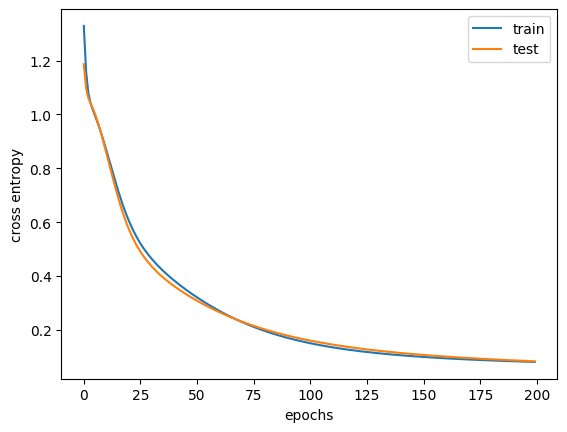

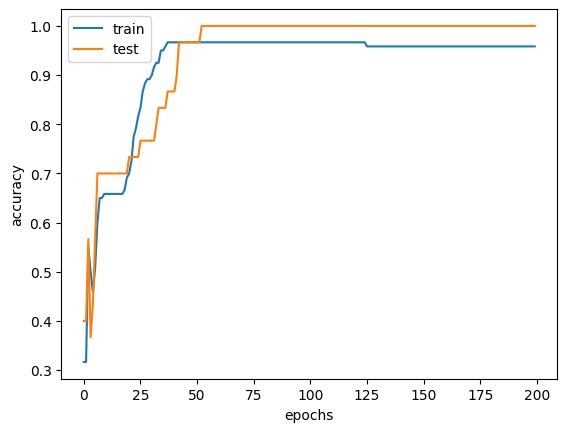

In [73]:
# Restore best model
model.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()